In [1]:
import numpy as np

In [2]:
from matplotlib import pyplot as plt

# Banana Collection DRL Report

This report presents the experiment results collected during the [Udacity DRL Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893)
[Project 1 - Navigation.](https://github.com/udacity/deep-reinforcement-learning/tree/master/p1_navigation). This report is organized as follows:
1) [Algorithm Details](#Algorithm-Details)
1) [Experimental Approach](#Experimental-Approach)
1) [Model Results](#Model-Results)
1) [Conclusion](#Conclusion)

## Algorithm Details

### Reinforcement Learning Theory

The environment, described in detail [here](https://github.com/joeworsh/drl_agent_navigation/blob/main/README.md), is well suited for a Deep Reinforcement Learning (DRL) approach. Reinforcement Learning, is a form of machine learning that is designed to optimize policies (i.e. decision makers) which know how to take optimal actions within an environment to reap some optimal reward or return from the environment. Mathematically we can represent the environment and the policy as:
<div style="font-size:16px">
$$\tag{1}
(s_{t+1}, r_{t+1}) = env(s_t, a_t),
$$
$$\tag{2}
a_t = \pi(s_t).
$$
</div>
where:

* $s_t$ is the environment state at time $t$
* $a_t$ is the action performed at time $t$
* $r_t$ is the reward from the environment received at time $t$
* $\pi$ denotes the policy which decides on the action to perform given the current environment state

This environment will run from time $0 \leq t \leq T$ with $T$ denoting the final timestep.

The objective is to find an optimal policy, denoted $\pi_*$, which maximizes the cumulative reward received over all time steps. This is more than just picking an action that will return the best $r_t$ at every timestep $t$, the agent must consider future rewards as well. There are instances where an undesirable action may lead to a larger reward many states in the future. It is important to optimize and that cumulative reward to learn more realistic and better performing policies. The cumulative return is defined at each timestep $t$ as the current reward and all future rewards (not including past rewards):
<div style="font-size:16px">
$$\tag{3}
G_t=\sum_{i=0}^{T-t} r_{t+i}.
$$
</div>

The difficulty here is that in practice we don't know these future rewards. The only thing we know with certainty is the past and current rewards. The best we can do here is predict the expected rewards the agent will receive if it were to follow a known policy $\pi$. This concept is denoted mathematically as:
<div style="font-size:16px">
$$\tag{4}
\tilde{G}_t=\mathbb{E}_\pi\left[\sum_{i=0}^{T-t} r_{\pi, t+i}\right]
$$
</div>
where $r_{\pi, i}$ is the reward received from $env(s_i, \pi(s_i))$. Here the policy $\pi$ is being used to anticipate the future states, and an expectation is used to represent uncertainty about those future returns.

One important addition must be made in order to handle this uncertainty: how confident are we in our ability to predict the future rewards? If we are very confident then it would make sense to consider all future rewards with equal weighting to ensure we getting the highest cumulative reward possible. However, if we're not confident in our ability to predict future rewards we need to consider that error to ensure we don't act too confidently when we're wrong. This is addressed with a discounting factor $0 \leq \gamma \leq 1$ which is exponentially applied at each timestep as:
<div style="font-size:16px">
$$\tag{5}
\tilde{G}_t=\mathbb{E}_\pi\left[\sum_{i=0}^{T-t} \gamma^i r_{\pi, t+i}\right].
$$
</div>
The farther this equations gets from the current time $t$ the smaller this discount factor gets. The discount is visualized below for several different values of $\gamma$ up $1000$ timesteps forward.

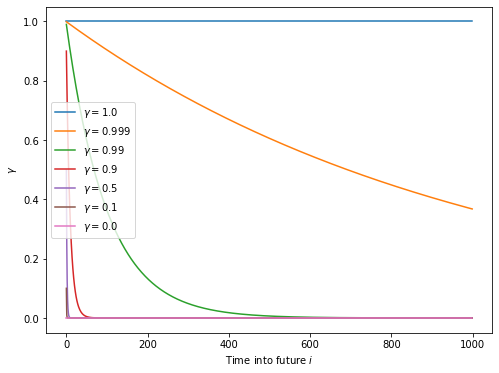

In [6]:
plt.figure(figsize=(8,6))
g_vals = [1.0, 0.999, 0.99, 0.9, 0.5, 0.1, 0.0]
g = np.array(g_vals).reshape([-1, 1])
g = np.tile(g, [1, 1000])
g = np.cumprod(g, axis=1)
for g_val, g_axis in zip(g_vals, g):
    plt.plot(g_axis, label=f"$\gamma={g_val}$")
plt.xlabel("Time into future $i$")
plt.ylabel("$\gamma$")
plt.legend()
plt.show()

It is evident here how far into the future each of these $\gamma$ values will look. The selection of $\gamma$ is of paramount importance with every Reinforcement Learning problem.

An important realization emerges while inspecting the formula of $\tilde{G}_t$ above. This represents the "score-to-go" where at the final timestep $T$, $G_T=r_T$ and $G_{T-1}=r_{T-1} + G_T$. This recursive pattern holds true for any value of $t$: $G_t=r_t+G_{t+1}$. This recursive pattern is the same pattern that is used in [Dynammic Programming](https://en.wikipedia.org/wiki/Dynamic_programming) (DP), which is the discipline of optimizing sequential (dynamic) problems. In DP this is called the [Bellman Equation](https://en.wikipedia.org/wiki/Bellman_equation) and is traditionally represented as the <b>value $v$</b> of a state. In the RL paradigm the value of a state (with discounting) is defined as:
<div style="font-size:16px">
$$\tag{6}
v_\pi(s)=\mathbb{E}_\pi\left[r_t + \gamma v_\pi(s_{t+1}) \; \middle| \; s_t=s\right].
$$
</div>

<a name="gamma"></a>This value function is important, but it still doesn't give any information on which action should be selected at any state. The value function can be adapted to consider the value of an action at any given state easily. This is called the <b>action-value</b> function, <b>$q$</b>:
<div style="font-size:16px">
$$\tag{7}
q_\pi(s, a)=\mathbb{E}_\pi\left[r_t + \gamma \; \underset{a_{t+1}}{\text{max}}\:q_\pi(s_{t+1}, a_{t+1}) \; \middle| \; s_t=s, a_t=a\right].
$$
</div>

$q_\pi$ tells us the expected cumulative return of selecting action $a$ given state $s$ and then continuing to follow policy $\pi$ until the episode ends. It accomplishes this was the recurrent relation from the Bellman Equation. The importance of this equation is that it identifies what truely needs to be learned for any decision making process. An optimal policy, $\pi_*$, will always select the action that maximizes it's expected cumulative return:
<div style="font-size:16px">
$$\tag{8}
\pi_*(s) = \underset{a}{arg\:\text{max}}\:q(s, a).
$$
</div>

The objective then is to learn a good representation of the action-value function $q$. If we can learn a good representation of $q$ then we know how to use it to act optimally within the environment.

### Learning $q(s, a)$

The action-value function can be represented by any parametric or non-parametric mathematical structure that is capable of handling the forms of $s$ and $a$ as inputs and producing a real-valued number as output. This is simple when $s$ and $a$ are both discrete options from a finite set. For example:

* $s \in \left[1, 2, 3, 4, 5, 6, 7, 8, 9 \right]$
* $a \in \left[\text{move up}, \text{move down}, \text{move left}, \text{move right} \right]$

which can represent discretes cell on a 3x3 grid and options to move in each direction. When states and actions are discrete like this a table can be used where the rows are the different states, the columns are the different actions and the value in each cell is $q(s, a)$. However, a table will not work if one or both of $s$ and $a$ are not integers that come from a finite set.

#### Deep Q-Networks

When the inputs are one or more real-valued numbers, represented by the $n$-dimensional vector $s \in \mathbb{R}^n$, this vector would need to be discretized in order to use a table to represent $q(s, a)$. However, it may not be feasible to discretize $s$ in a way that is both sufficiently representative and computationally feasible. In this case a model capable of handling real-valued vector input, such as a [neural network](https://en.wikipedia.org/wiki/Neural_network), is required. In this case the input to the neural network is the real-valued $n$-dimensional vector $s$ and it has an output node for each of the $m$ actions. The value in each of the output cells corresponds to the action-value for the input cell and the associated action. An example of this neural network architecture is shown below:

<div style="text-align:center;">
<img src="docs/nn_q_example.png" alt="Neural Q-Network architecture example">
</div>

Neural networks are parameterized by a set of learnable weights and biases denoted as the learnable parameters $\theta$. These weights allow the network to represent any function that is intended to be learned in a machine learning problem. The correct values of $\theta$ are learned incrementally by computing a loss, that evaluates how well a neural network is performing, and then making small updates to $\theta$ that will improve the loss. Overtime these values will converge on an optimized set of parameters that enable the neural network to make intelligent decisions related to the problem it was trained on. When using a parameterized model, like a neural network, the parameters $\theta$ will be shown as an input to the action-value function to indicate which model is being used to compute the value: $q(s, a; \theta)$.

In RL, specifically Q-Learning, the loss is defined as:
<div style="font-size:16px">
$$\tag{9}
\ell(\theta)=\mathbb{E}_{(s,a,r,s') \sim p(D)}\left[\left(r + \gamma \; \underset{a'}{\text{max}}\:q(s', a'; \theta^{-}) - q(s, a; \theta)\right)^2\right].
$$
</div>

This loss can seem intimidating at first but it can be simply broken down and will begin to look like a standard [mean-squared-error](https://en.wikipedia.org/wiki/Mean_squared_error) which is common in any machine learning or regression problem.

<a name="prioritized_replay"></a>First, observe that the inputs to the action-value function in the loss function, $(s, a, r, s')$ are sample from a dataset $D$ distributed according to some probability of the samples within dataset $D$. We assume that we have a dataset of experiences, capturing previously seens states, the action that was performed at the state, the reward that was received and the state that followed. This tuple represents a single experience that we wish to learn from. As we engage with the environment we are building this dataset with real experiences that our model is having. The likelihood of this dataset, $p(D)$ helps to determine which experiences we should learn from. This could be a simple uniform distribution, i.e. $p(D) \triangleq U(d)$, or it adapt to give a higher likelihood to experiences that the model is not as familiar with. The latter is called <i>Prioritized Experience Replay</i> [[1]](#1) and it uses the magnitude of the loss above to decide how familiar the model is with that experience. When the loss is larger for some sample it will be more likely to see that sample again. The $\mathbb{E}_{(s,a,r,s') \sim p(D)}$ component of the loss function is simply showing that while learning the experiences we are learning on are being sampled from that dataset.

The next component to understand is $q(s, a; \theta)$ which tells us what the model, parameterized by $\theta$, thinks the action-value function for $s$ and $a$ should be. This is ultimately the value we hope our model will be able to produce accurately. It is used here as the prediction input to a mean-squared-error loss function.

Finally, $r + \gamma \; \underset{a'}{\text{max}}\:q(s', a'; \theta^{-})$ acts as an approximation of the actual value we hope our model will learn to represent. Ultimately we hope that our model will learn the true cumulative reward that follows any state action pair - however it would be computationally inefficient if we were to simulate full episodes and train only on sequential experiences. It is far more important that we can learn from individual experiences which is why the cumulative return is approximated by the known reward given for an experience and the approximated return of the next state: $\underset{a'}{\text{max}}\:q(s', a'; \theta^{-})$.

##### Target Networks

Notice that in the loss function above there are two sets of learnable parameters present: $\theta$ and $\theta^-$. This is an important feature of the Deep Q-Network (DQN) [[2]](#2) which helps to address an important problem that causes divergence while training. If $\theta$ were used directly to compute both the label and prediction, as described above, it would be equivalent to trying to optimize on a moving target. It's as if the model is a dog chasing the its own tail: as it gets closer to its tail the tail pulls away. Interestingly Mnih et al [[2]](#2) showed that this circular dependency can be broken by simply creating a <i>target</i> network that lags slightly behind the learned model, denoted $\theta^-$. An additional hyperparameter is added that controls how often the target network parameters $\theta^-$ are updated towards the actual $\theta$ values.

##### Double Q-Networks

An important discovery regarding DQN performance, presented by Van Hasselt et al [[3]](#3), is that the DQN is susceptable to overestimating the value of actions. This overestimation can lead to poor performance during training because it always selects the action with the highest estimated value when computing the loss. Overestimation can destabilize training and cause the learner to pursue policies that are not optimal in the context of the environment. One way to address this overestimation is regularize the estimating with another Q model that must learn to agree on which actions are best. It easy to see how Equation 7 can be rewritten to split the <i>max</i> operation into a call to $q$ and an <i>argmax</i> call:
<div style="font-size:16px">
$$\tag{10}
q_\pi(s, a)=\mathbb{E}_\pi\left[r_t + \gamma \; q(s_{t+1}, \underset{a}{arg\:\text{max}}\:q(s_{t+1}, a; \theta); \theta^{-}) \; \middle| \; s_t=s, a_t=a\right].
$$
</div>

Note that the primary network, called the online network, is used to decide which action is best but the target network, $\theta^{-}$, is used to estimate the value of the selected action. It has been proven that this discontinuation is powerful enough to help stabilize the learning process [[3]](#3). When put into the loss function it now looks like:
<div style="font-size:16px">
$$\tag{11}
\ell(\theta)=\mathbb{E}_{(s,a,r,s') \sim p(D)}\left[\left(r + \gamma \; q(s', \underset{a'}{arg\:\text{max}}\:q(s', a'; \theta); \theta^{-}) - q(s, a; \theta)\right)^2\right].
$$
</div>

##### Dueling Q-Networks

One final improvement to the vanilla DQN will be mentioned here: the dueling DQN [[4]](#4). In the RL literature the value of a state $v(s)$ is related to the action-value $q(s, a)$ through the <i>advantage</i>, $A(s, a)$ of the action $a$ in state $s$:
<div style="font-size:16px">
$$\tag{12}
q(s, a)=v(s)+A(s, a).
$$
</div>
In the same way that creating a Double DQN helps to eliminate internal interdependency to stabilize training, a network can be updated to independently predict both the value and advantage and then combine them to produce $q(s, a)$ [[4]](#4). An example of a Dueling DQN architecture is shown below:
<div style="text-align:center;">
<img src="docs/deuling_dqn_architecture.png" alt="Deuling DQN Architecture">
</div>

## Experimental Approach

In this project, a DQN [[2]](#2) with options to support Prioritized Replay [[1]](#1), Double DQN [[3]](#3) and Dueling DQN [[4]](#4) is implemented using only [PyTorch](https://pytorch.org/). The objective of this project is to train an agent that is capable of the winning the Banana Collection game by getting an average score of 13 or greater over 100 episodes. The way to achieve this goal is to implement the code correctly and find a set of hyperparameter values that enables good learning for this environment.

The hyperparameters that may be tuned for this model are as follows:
* <code>hidden_layers</code>: comma-separated list of integers describing the number of nodes in each layer (where the length of the list describes the number of layers). Defaults to <code>[256,]</code>.
* <code>episodes</code>: The number of episodes to train over. Defaults to <code>10000</code>.
* <code>batch_size</code>: The number of (s, a, r, s') experiences included in each mini-batch. Defaults to <code>128</code>.
* <code>buffer_size</code>: The experience replay buffer is first-in-first-out structure. This parameter sets the maximum number of entires that can be in the buffer at the same time. Defaults to <code>10000</code>.
* <code>update_rate</code>: Sets the rate, in steps, at which the online network parameters $\theta$ are trained. Defaults to <code>10</code>.
* <code>learning_rate</code>: Sets the step size to use during stochastic gradient descent updates. Defaults to <code>1e-3</code>.
* <code>discount_rate</code>: Sets the value of $\gamma$ as described [above](#gamma). Defaults to <code>1e-3</code>.
* <code>epsilon</code>: Sets the starting value of $\epsilon$ for an $\epsilon$-greedy policy. Defaults to <code>1</code>.
* <code>epsilon_decay</code>: Sets the exponential decay rate for $\epsilon$. $\epsilon_{i+1}=\text{epsilon_decay}*\epsilon_i$. Defaults to <code>0.99</code>.
* <code>epsilon_decay_rate</code>: Sets the rate, in epsidoes, at which to apply the epsilon to decay. When set to 1 this creates a smooth, continuous curve for $\epsilon$. When set to a larger integer it will create a stair-step function with each stair width being equal to this decay rate. Defaults to <code>1000</code>.
* <code>min_epsilon</code>: Sets minimum allowable value of $\epsilon$ while decaying. Once this minimum is hit it will stop decaying. Defaults to <code>1e-1</code>.
* <code>tau</code>: Controls the step size used when updating the target network parameters $\theta^{-}$ towards the online network $\theta$. This step is performed at the update rate defined above. Defaults to <code>1e-3</code>.
* <code>replay</code>: Determine the type of replay buffer to use. Options: "uniform" to sample $U(D)$; "prioritized" to sample with priority sampling as described [above](#prioritized_replay). Defaults to <code>uniform</code>.
* <code>prioritized_replay_damp</code>: Sets the damping term $\alpha$ when using prioritized replay as defined by Schaul et al [[1]](#1) where $0 \leq \alpha \leq 1$. Defaults to <code>0.1</code>.
* <code>e_constant</code>: Sets constant $e$ when using prioritized replay to ensure samples don't get starved out [[1]](#1). Defaults to <code>0.01</code>.
* <code>prioritized_replay_beta_anneal_rate</code>: Sets the $\beta$ annealing rate, in episodes, when using prioritized replay as defined by Schaul et al [[1]](#1). $\beta$ starts at 1 and anneals towards zero at the rate defined over training. Defaults to <code>1</code> (i.e. every episode it decays toward zero).
* <code>learning_start</code>: The required number of experiences in the buffer before learning will officially start. Defaults to <code>1000</code>.
* <code>double_dqn</code>: <code>True</code> to use a [Double DQN](#Double-Q-Networks) approach; <code>False</code> otherwise. Defaults to <code>False</code>.
* <code>dueling_dqn</code>: <code>True</code> to use a [Dueling DQN](#Dueling-Q-Networks) approach; <code>False</code> otherwise. Defaults to <code>False</code>.

In this project three different experiments are performed:
1) Train a network with some good default values (according to open source libraries like [RLLib](https://docs.ray.io/en/master/rllib.html))
1) Perform a grid search over the most important set of hyperparameters
1) Perform a training run with [RLLib](https://docs.ray.io/en/master/rllib.html)) to act as a reference benchmark

The results of these three experiments are presented below.

## Model Results

### Experiment 1 - Good Default Parameters

In this experiment a model is trained with the parameters listed below. Parameters that are not included in the list fallback to the default values listed above. With the default hidden layers set, this is a simple 3-layer feed forward network with the hidden layer having 256 nodes. This architecture is used in all experiments shown below.

In [7]:
params = {
    "episodes": 5000,
    "batch_size": 64,
    "learning_rate": 5e-4,
    "discount_rate": 0.99,
    "update_rate": 4,
    "epsilon_decay": 0.99,
    "epsilon_decay_rate": 1,
    "min_epsilon": 0.01,
    "replay": "prioritized",
    "prioritized_replay_damp": 0.6,
    "e_constant": 1e-6,
    "prioritized_replay_beta_anneal_rate": 100,
    "learning_start": 64,
    "double_dqn": True,
    "deuling_dqn": True
}

This parameter set is identified as model <i>a</i>. The cumalitive reward of each episode over training and the epsilon values at each episode are shown below:

<div style="text-align:center;">
<img src="docs/exp_1/scores.png">
<img src="docs/exp_1/epsilons.png">
</div>

It is evident looking at this chart that the learning climbs steadily to an average of about 13 points before it plateaus and ceases to make any improvements. It would appear that this stagnation correlates with the epsilon value fully decaying around the same training episode - somewhere between 500 and 1000. Let's explore this correlation further with another training attempt. We'll use all the same parameter values above, but this time we'll set the <code>epsilon_decay</code> to $0.999$. The model trained with this new epsilon decay rate is labeled model <i>b</i>. The cumulative reward and epsilon values at each episode are shown below:

<div style="text-align:center;">
<img src="docs/exp_1/scores_b.png">
<img src="docs/exp_1/epsilons_b.png">
</div>

The real test is now using an optimal policy based on the action-value function represented by these models on the banana environment. The evaluation will consist of running 100 concesutive episodes and recording the average score. The goal is to get an average of 13 points or higher. First, the scores of 100 runs with model <i>a</i>:

<div style="text-align:center;">
<img src="docs/exp_1/eval_a.png">
</div>

The average score for model <i>a</i> over these 100 test episodes was <b>9.54</b>. The model came close and has clearly learned something, but it has fallen short of the goal of 13. While analyzing the performance of this trained model it became evident that it was confidently able to pick up yellow bananas when they were grouped together (leading to the higher scoring episodes), however, when there were a lot of blue bananas or few yellow bananas it became indecisive and would simply move side to side until the episode ended. It would appear this model was disproportionately afraid of picking up a blue banana even if it meant getting more yellow bananas farther along in the episode.

The scores over 100 evaluation episodes with model <i>b</i> are shown below:

<div style="text-align:center;">
<img src="docs/exp_1/eval_b.png">
</div>

The average score for model <i>b</i> is <b>15.37</b>. With the slower epsilon decay it has been shown that a model can learn a winning policy to the banana collection game. If readers are interested in trying out this policy for themselves they may check out the repository, follow the setup documented in [README.md](https://github.com/joeworsh/drl_agent_navigation/blob/main/README.md) and run the notebook [DQN Evaluate 2](https://github.com/joeworsh/drl_agent_navigation/blob/main/DQN%20Evaluate%202.ipynb).

### Experiment 2 - Grid Search over Parameters

Given the vast number of parameter configurations that exist for this problem space it would be impossible to write out every candidate configuration and test it manually. There are, however, many interesting parameter search techniques that can automate this process. For this project a simple [grid search](https://en.wikipedia.org/wiki/Hyperparameter_optimization#Grid_search) was used to try all the different interesting combinations. In particular the grid search was concerned with these parameters and the associated values:
* <code>buffer_size</code>: [10000, 50000]
* <code>learning_rate</code>: [5e-4, 1e-3, 1e-2]
* <code>discount_rate</code>: [0.9, 0.99, 0.999]
* <code>update_rate</code>: [4, 10]
* <code>epsilon_decay</code>: [0.9, 0.995, 0.999]
* <code>min_epsilon</code>: [0.01, 0.1]
* <code>replay</code>: [uniform, prioritized]
* <code>double_dqn</code>: [False, True]
* <code>deuling_dqn</code>: [False, True]

Each test in the grid search trained on 1000 episodes. This grid search was a little too ambitious as it in total was requested to evaluate 1,728 configurations with each configuration requiring about an hour to train. Regardless, this grid search was able to explore many of the varied configurations before being terminated. The average scores over 100 evaluation episodes of that grid search are below:

<div style="text-align:center;">
<img src="docs/exp_2/grid_search.png">
</div>

Readers can see that one experiment in this grid search that was able to come very close to the desired score of 13 in only 1000 trained episodes: <code>exp_7</code>. The hyperparameters for <code>exp_7</code> are shown below:

Params:
* <code>episodes</code>: 1000
* <code>batch_size</code>: 64
* <code>buffer_size</code>: 10000
* <code>learning_rate</code>: 0.0005
* <code>discount_rate</code>: 0.9
* <code>update_rate</code>: 4
* <code>epsilon_decay</code>: 0.9
* <code>epsilon_decay_rate</code>: 1
* <code>min_epsilon</code>: 0.01
* <code>replay</code>: prioritized
* <code>prioritized_replay_damp</code>: 0.6
* <code>e_constant</code>: 1e-06
* <code>prioritized_replay_beta_anneal_rate</code>: 100
* <code>learning_start</code>: 64
* <code>double_dqn</code>: True
* <code>deuling_dqn</code>: True

This configuration achieved an average score of <b>12.7</b> over 100 episodes. It came very close yet still fell slightly short.

Other results from the grid search can be seen in the [Analyze Results](https://github.com/joeworsh/drl_agent_navigation/blob/main/Analyze%20Results.ipynb) notebook.

### Experiment 3 - RLLib Benchmark

Finally, as a benchmark test, an experiment is performed using [RLLib](https://docs.ray.io/en/master/rllib.html) which is an industry standard open source library for DRL. All of the default parameters are used with their DQN implementation. The averaged score over training is shown below:

<div style="text-align:center;">
<img src="docs/exp_3/scores.png">
</div>

These scores are averaged but appear to follow the same trend as the models in experiment 1. The default parameters for the DQN model can be seen [here](https://docs.ray.io/en/master/rllib-algorithms.html#dqn).

This experiment builds confidence in the implementation presented and demonstrates how to use RLLib with a custom environment. The implementation can be seen in the [RLLib Test](https://github.com/joeworsh/drl_agent_navigation/blob/main/RLLib%20Test.ipynb) notebook.

## Ideas for Future Work

A DQN model exists that pulls together all the discovered improvements, including the 3 listed above, called Rainbow DQN [[5]](#5). When using DQN approaches in academia or in industry the standard is to use Rainbow DQN. RLLib also contains a trustworthy implementation that can be used open-source. Another interesting avenue of research would be to compare DQN performance on the Banana Collection game against policy-gradient methods which learn policies via actor-critic paradigms. In practice, policy-gradient methods, such as Soft Actor Critic [[6]](#6) and Proximal Policy Optimization [[7]](#7), out-perform or perform competitively against DQN approaches. Finally, these experiments consumed environment inputs as real-valued state vectors, however, it would be advantageuous to evaluate how well DQN can perform when it takes in image data as input. This would require a different neural network architecture with a CNN input block. Image inputs with CNNs are presented by Schaul et al [[1]](#1).

## Conclusion

This report presents an overview of the Deep Q-Network and the Reinforcement Learning theory behind it. The repository provides an implementation of the DQN using PyTorch including the concepts of prioritized experience replay, double DQN and dueling DQN. Results are shown training this model on the Unity banana collection environment. With some fairly standard hyperparameter values a model is able to achieve an average score of 15.37 surpassing the goal of 13 in 5000 training episodes. This winning model used both Double DQN and Dueling DQN approaches. Additionally, a bechmark test is included using RLLib to determine the validity of the implementation presented.

# References

<a name="1">[1]</a> Schaul, Tom, et al. "Prioritized experience replay." arXiv preprint arXiv:1511.05952 (2015).

<a name="2">[2]</a> Mnih, Volodymyr, et al. "Human-level control through deep reinforcement learning." nature 518.7540 (2015): 529-533.

<a name="3">[3]</a> Van Hasselt, Hado, Arthur Guez, and David Silver. "Deep reinforcement learning with double q-learning." Proceedings of the AAAI Conference on Artificial Intelligence. Vol. 30. No. 1. 2016.

<a name="4">[4]</a> Wang, Ziyu, et al. "Dueling network architectures for deep reinforcement learning." International conference on machine learning. PMLR, 2016.

<a name="5">[5]</a> Hessel, Matteo, et al. "Rainbow: Combining improvements in deep reinforcement learning." Proceedings of the AAAI Conference on Artificial Intelligence. Vol. 32. No. 1. 2018.

<a name="6">[6]</a> Haarnoja, Tuomas, et al. "Soft actor-critic: Off-policy maximum entropy deep reinforcement learning with a stochastic actor." International Conference on Machine Learning. PMLR, 2018.

<a name="7">[7]</a> Schulman, John, et al. "Proximal policy optimization algorithms." arXiv preprint arXiv:1707.06347 (2017).